### ReadRheology [Brice]

Ce programme vous simplifie la vie pour importer des données des rhéomètres Anton Paar [RheoCompass] et Malvern [rSpace], du format .csv ou .txt vers Python, puis de les tracer simplement à l'aide du paquet [Bokeh](https://bokeh.org/), facilement installable avec `pip`. 

Les principales fonctions sont placées dans le fichier `rheol_functions.py`, qui contient : 

* le code principal qui lit les fichiers `.csv` : `read_rheology()`. Le programme détecte les fichiers Malvern ou Anton Paar, découpe proprement les étapes (step / interval), gère (normalement) les données de LAOS et renvoie un tableau (Pandas Dataframe). Il renomme les colonnes courantes (contrainte, déformation, etc.) en des identifiants simples (`stress`, `strain`, ...)
* une fonction de 'confort' :  `slice` permettant de renvoyer un sous-tableau contenant les étapes qui vous intéressent.
* une autre fonction de confort :  `assign_steps`, permettant de définir un 'type' pour chaque étape, qui pourra être reconnu plus tard par les fonctions de tracé.
* des fonctions de tracé :  `plot_flowcurve()`, `plot_fsweep()`, `plot_asweep()`, `plot_tsweep()` qui permettent de tracer correctement vos courbes d'écoulement, balayages en amplitude et en fréquence, etc. Il est bien sûr possible de superposer ces tracés si vous leur donnez à manger un tableau contenant plusieurs étapes.

#### Utilisation de base :

In [24]:
# READRHEOLOGY : reads

import rheol_functions as rh

# Load file
file = 'Z:/AntonPaar/Carbopol 20230906_full.csv'

data = rh.read_rheology(file)                       # Read the file
data = rh.assign_steps(data, [3,4], 'flowcurve')    # Say that steps 3 and 4 are `flow curves`
rh.list_steps(data)                                 # List all the steps
flowcurves = rh.slice(data,[3])                     # Select step 3
fig, fit = rh.plot_flowcurve(flowcurves)                       # Plot the flow curves of step 3

read_rheology > Z:/AntonPaar/Carbopol 20230906_full.csv is an Anton Paar file
assign_steps > step : 3 | Assigning as : flowcurve
assign_steps > step : 4 | Assigning as : flowcurve
------------- Step list in DataFrame --------------------
  * Step n°1 	 :                             Flow Curve 1	 is a                 | Duration :      60.00 s | Total time is :      60.00 s
  * Step n°2 	 :                             Flow Curve 1	 is a                 | Is a bit mysterious
  * Step n°3 	 :                             Flow Curve 1	 is a       flowcurve | Duration :     204.00 s | Total time is :     284.00 s
  * Step n°4 	 :                             Flow Curve 1	 is a       flowcurve | Duration :     204.00 s | Total time is :     488.00 s
  * Step n°5 	 :                                   LAOS 1	 is a                 | Duration :     200.00 s | Total time is :     688.00 s
  * Step n°6 	 :                                   LAOS 1	 is a                 | Duration :      30.00 s | Tota

In [ ]:
data['point']

0        1.0
1        2.0
2        3.0
3        4.0
4        5.0
        ... 
4594    19.0
4595    20.0
4596    21.0
4597    22.0
4598    23.0
Name: point, Length: 4599, dtype: object

In [ ]:
# Your plots here !

#### Utilisation plus avancée des fonctions de LAOS : 

Ici, on va utiliser les fonctions

* `proj_fourier()` :  qui projette un signal sur une série de Fourier. Il est un peu bête, donc il faut lui donner à manger un temps normalisé par la fréquence angulaire (0 à 2 $\pi$ pour une période) et c'est mieux de lui donner un nombre entier et pair de périodes. Sinon vos coefficients de la projection vont déconner. Le programme renvoie un `dict` contenant à la fois la partie réelle et imaginaire des harmoniques $k$, (respectivement `sin` et `cos`), mais également leur module (`amp`) et phase (`phs`). 
* `build_fourier()` :  qui reconstruit le signal à partir du dictionnaire des harmoniques $k$ et une base de temps, pour notamment vérifier la qualité de votre projection.

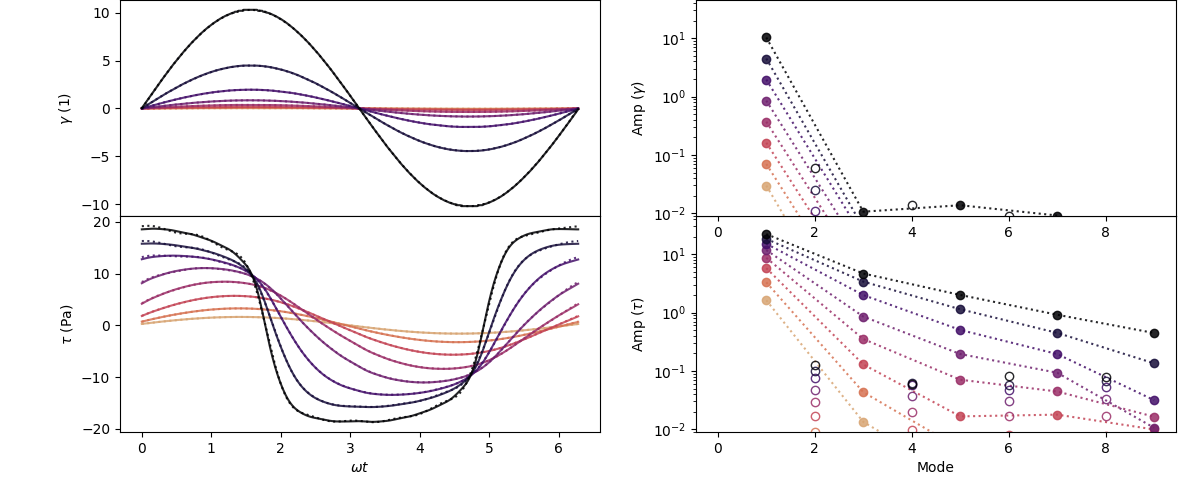

In [26]:
# Example of a LAOS raw data plot for Anton Paar
# The Anton Paar LAOS Step (n°7 here) has multiple oscillation
# amplitudes. 

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt


rawlaos = data[data['raw'] & (data['step'] == 7)]
synlaos = data[~data['raw'] & (data['step'] == 7)]

cmap = cm.magma_r

%matplotlib widget

fig = plt.figure()
ax0 = fig.add_axes([0.10,0.55,0.4,0.45])
ax1 = fig.add_axes([0.10,0.10,0.4,0.45])
ax2 = fig.add_axes([0.58,0.10,0.4,0.45])
ax3 = fig.add_axes([0.58,0.55,0.4,0.45])

for pt in np.unique(rawlaos['point'][:]):
    color = 0.85*np.array(cmap(pt/8))
    select = rawlaos[rawlaos['point'] == pt]
    f = np.squeeze(np.unique(select['freq']))
    t_rebuilt = np.linspace(0, 1/f, len(select))*2*np.pi*f

    proj_gam = rh.proj_fourier(t_rebuilt, select['raw_oscstrain'], nmodes=10)
    proj_tau = rh.proj_fourier(t_rebuilt, select['raw_oscstress'], nmodes=10)
    fit_gam = rh.build_fourier(proj_gam, t_rebuilt, nmodes=10)
    fit_tau = rh.build_fourier(proj_tau, t_rebuilt, nmodes=10)

    # Plotting
    ax0.plot(t_rebuilt, select['raw_oscstrain'], '-',  color=color)
    ax0.plot(t_rebuilt, fit_gam, ':',  color=color)
    ax1.plot(t_rebuilt, select['raw_oscstress'], '-', color=color)
    ax1.plot(t_rebuilt, fit_tau, ':', color=color)
    ax2.semilogy(proj_tau['mode'][1::2], proj_tau['amp'][1::2], ':o', color=color)
    ax3.semilogy(proj_gam['mode'][1::2], proj_gam['amp'][1::2], ':o', color=color)
    ax2.semilogy(proj_tau['mode'][::2], proj_tau['amp'][::2], 'o', markeredgecolor=color, markerfacecolor='None')
    ax3.semilogy(proj_gam['mode'][::2], proj_gam['amp'][::2], 'o', markeredgecolor=color, markerfacecolor='None') 

# Format plot
ax1.set_xlabel('$\\omega t$')
ax1.set_ylabel('$\\tau$ (Pa)')
ax0.set_ylabel('$\\gamma$ (1)')
ax2.set_xlabel('Mode')
ax2.set_ylabel('Amp ($\\tau$)')
ax3.set_ylabel('Amp ($\\gamma$)')
ax2.set_ylim([1e-3*np.max(proj_tau['mode']), 5*np.max(proj_tau['mode'])])
ax3.set_ylim([1e-3*np.max(proj_tau['mode']), 5*np.max(proj_tau['mode'])])
fig.set_figwidth(12)